# Оптимизация издержек предприятия

**Цель работы:**

Оптимизировать производственные расходы, путем уменьшения потребления электроэнергии на этапе обработки стали. 

**Задача:**

Разработать предсказательную модель температуры расплавленного состояния сплава, которая поспособствует бизнесу в работе над своими издержками.

**План работы**

1. План и исследование данных

    - Исследование исследование данных, визуализация распределений, установление взаимосвязей.
    - Составление плана работы
    - Составление предварительного списка признаков
    - Составление списка вопросов

2. Предобработка данных 
    - Устранение аномалий, заполнение пропусков.
    - Генерация новых признаков
    - Агрегирование данных по ключу.

3. Разработка модели
    - Исследование объединённого датафрейма, предобработка для загрузки данных в модели
    - Выбор моделей для разработки. (Возможно среди них будет кэтбуст, но пока не знаю)
    - Разделение на выборки и масштабирование
    - Подбор гиперпараметров, получение метрики на кросс-валидации, выбор лучшей модели
    - Проверка качества лучшей модели на тестовой выборке

**Описание данных**

Данные состоят из файлов, полученных из разных источников:

- `data_arc.csv` — данные об электродах;
- `data_bulk.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time.csv` *—* данные о подаче сыпучих материалов (время);
- `data_gas.csv` — данные о продувке сплава газом;
- `data_temp.csv` — результаты измерения температуры;
- `data_wire.csv` — данные о проволочных материалах (объём);
- `data_wire_time.csv` — данные о проволочных материалах (время).

## Изучение данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import numpy as np
from scipy.stats import spearmanr

# игнорирование предупреждений о несоответствии версий
import warnings
warnings.filterwarnings('ignore')

# работа с таблицами
import pandas as pd

# визуализация
import matplotlib.pyplot as plt
import seaborn as sns

# Работа с матрицами
import numpy as np

# модели
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

!pip install -q catboost
from catboost import CatBoostRegressor

# вспомогательные инструменты
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split
from scipy.stats import uniform

from sklearn import set_config
set_config(display='diagram')

# Проверим признаки на корреляцию
! pip install phik
import phik
from phik import resources, report

     |████████████████████████████████| 679 kB 1.1 MB/s eta 0:00:01


In [2]:
data_arc = pd.read_csv('/datasets/final_steel/data_arc.csv')
data_bulk = pd.read_csv('/datasets/final_steel/data_bulk.csv')
data_bulk_time = pd.read_csv('/datasets/final_steel/data_bulk_time.csv')
data_gas = pd.read_csv('/datasets/final_steel/data_gas.csv')
data_temp = pd.read_csv('/datasets/final_steel/data_temp.csv')
data_wire = pd.read_csv('/datasets/final_steel/data_wire.csv')
data_wire_time = pd.read_csv('/datasets/final_steel/data_wire_time.csv')

data_list = [data_arc, data_bulk, data_bulk_time, data_gas, data_temp, data_wire, data_wire_time]

Данные состоят из семи датасетов, которые содержат информацию о работе электрических электродов, количестве реагентов, газа и материалов в виде проволоки. По каждому процессу кроме подачи газа известно точное время.

In [3]:
# Функция информации о таблице
def info(data):
    return display(data.head(), data.shape, data.info(), data.describe())

In [4]:
# змеиный регистр для  быстрого выделения названий столбцов
def register(data):
    name = []
    
    for i in data.columns:
        letter = []
        for j in i:
            if j == ' ':
                letter.append('_')
            else:    
                letter.append(j.lower())
        name.append(''.join(letter))
    
    return name

### **data_arc** - данные об электродах

In [5]:
data_arc.columns = register(data_arc)

In [6]:
info(data_arc)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   начало_нагрева_дугой  14876 non-null  object 
 2   конец_нагрева_дугой   14876 non-null  object 
 3   активная_мощность     14876 non-null  float64
 4   реактивная_мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


,key,начало_нагрева_дугой,конец_нагрева_дугой,активная_мощность,реактивная_мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397


(14876, 5)

None

,key,активная_мощность,реактивная_мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.670441,0.452592
std,934.571502,0.408159,5.878702
min,1.000000,0.030002,-715.504924
25%,806.000000,0.395297,0.290991
50%,1617.000000,0.555517,0.415962
75%,2429.000000,0.857034,0.637371
max,3241.000000,3.731596,2.676388


Предварительно можно сказать, что в таблице нет пропусков, однако имеются аномально низкие значения в столбце реактивная_мощность.
Предположительные единицы измерения столбцов Мегаватт и Мегавольт Ампер реактивный.

In [7]:
# перевод дат в формат дат
data_arc['начало_нагрева_дугой'] = pd.to_datetime(
    data_arc['начало_нагрева_дугой'], format='%Y-%m-%d %H:%M:%S')

data_arc['конец_нагрева_дугой'] = pd.to_datetime(
    data_arc['конец_нагрева_дугой'], format='%Y-%m-%d %H:%M:%S')

**Распределение значений**

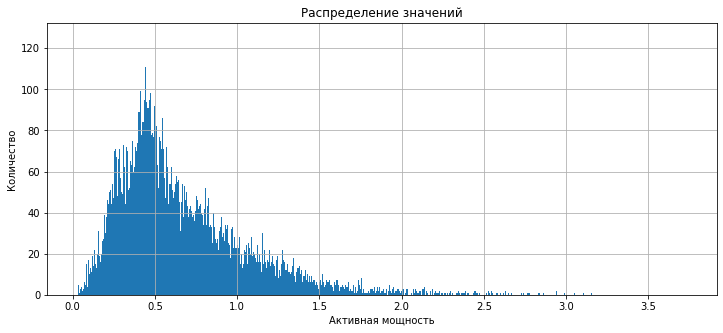

In [8]:
data_arc['активная_мощность'].hist(bins=1000, figsize=(12,5))
plt.title('Распределение значений')
plt.ylabel('Количество')
plt.xlabel('Активная мощность')
plt.show()

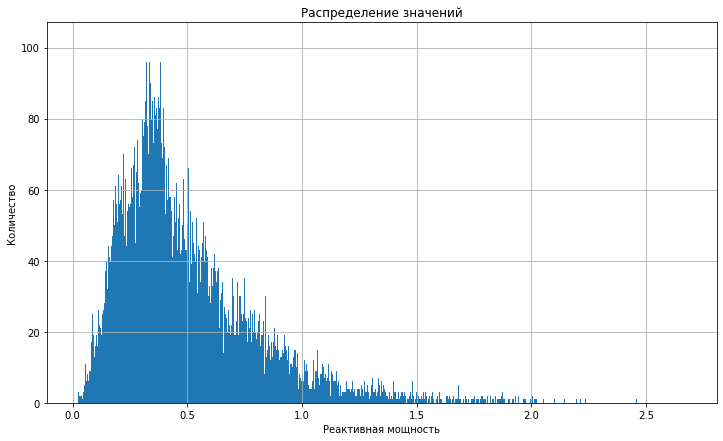

In [9]:
data_arc[data_arc['реактивная_мощность'] > -1]['реактивная_мощность'].hist(bins=1000, figsize=(12,7))
plt.title('Распределение значений')
plt.ylabel('Количество')
plt.xlabel('Реактивная мощность')
plt.show()

**Проверка данных на корреляцию**

In [10]:
data_arc.corr(method='pearson')

,key,активная_мощность,реактивная_мощность
key,1.000000,-0.021382,-0.004396
активная_мощность,-0.021382,1.000000,0.054437
реактивная_мощность,-0.004396,0.054437,1.000000


In [11]:
rho, p = spearmanr(data_arc['активная_мощность'], data_arc['реактивная_мощность'])
print(rho, p)

0.9693732690504825 0.0


Корреляция Пирсона показывает низкую взаимосвязь, при этом, ранговая корреляция Спирмана позволила определить статистически значимую взаимосвязь несмотря на выбросы.

In [12]:
data_arc.drop(index=data_arc[data_arc['реактивная_мощность'] < 0].index).corr(method='pearson')

,key,активная_мощность,реактивная_мощность
key,1.000000,-0.021367,-0.000159
активная_мощность,-0.021367,1.000000,0.963182
реактивная_мощность,-0.000159,0.963182,1.000000


In [13]:
data_arc = data_arc.drop(index=data_arc[data_arc['реактивная_мощность'] < 0].index)

In [14]:
rho, p = spearmanr(data_arc['активная_мощность'], data_arc['реактивная_мощность'])
print(rho, p)

0.9694408472607176 0.0


Отсутствие выброса привело к адекватным значениям корреляции Пирсона.

Данные имеют нормальное распределение в обоих столбцах, однако есть необходимость очистки данных от выбросов. Имеют место скачки  активной мощности в пределах 3.73 Мегаватт, что также влияет на показатели реактивной мощности.

**Зависимость данных от времени**

In [15]:
data_arc_plot = data_arc.set_index('конец_нагрева_дугой')

In [16]:
data_arc_plot = data_arc_plot.drop(columns=['key', 'реактивная_мощность'])

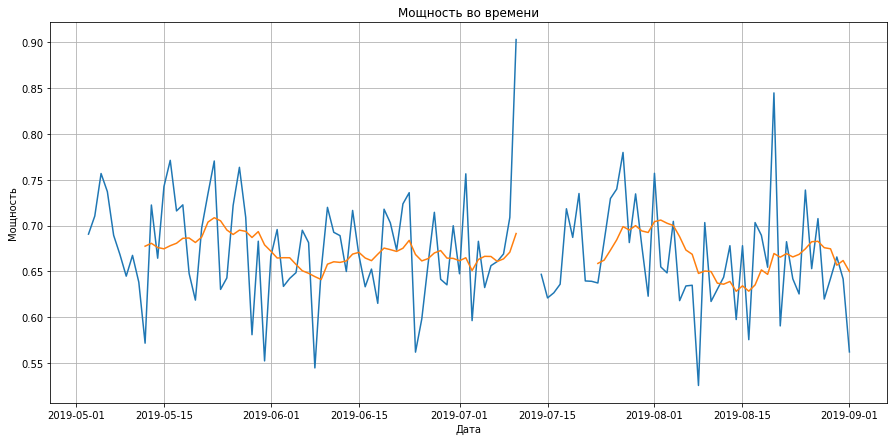

In [17]:
plt.figure(figsize=(15, 7))
plt.xlabel('Дата')
plt.ylabel('Мощность')
plt.title('Мощность во времени')
ax = plt.plot(data_arc_plot.resample('1D').mean())
plt.plot(data_arc_plot.resample('1D').mean().rolling(10).mean())
#plt.xlim([datetime.date(2019, 7, 1), datetime.date(2019, 7, 15)])
plt.grid(True)
plt.show()

Имеется зависимость данных от времени, 1-2 раз в неделю наблюдается снижение средней можности за день. Также имеется выброс мощности, что может быть свидетельством аварийного случая, где после скачка напряжения, данные о работе в течение четырех дней отсутствуют.

### data_bulk — данные о подаче сыпучих материалов (объём);

In [18]:
info(data_bulk)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


(3129, 16)

None

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


В таблице имеется много пропусков, есть предположение, что сыпучие материалы подаются из разных емкостей, некоторые не участвуют в конкретной итерации. Даным соответствует талица data_bulk_time, которая отражает время подачи материала. Рассмотрим суммарное значение количества материалов на партию.

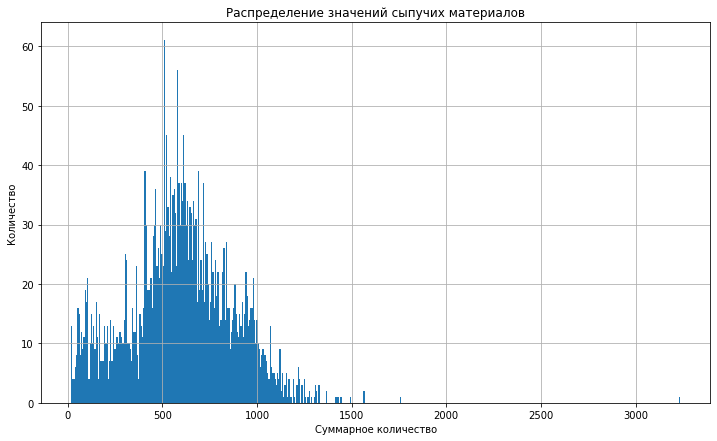

In [19]:
data_bulk.drop(columns=['key']).sum(axis=1).hist(bins=500, figsize=(12,7))
plt.title('Распределение значений сыпучих материалов')
plt.ylabel('Количество')
plt.xlabel('Суммарное количество')
plt.show()

Можно сказать, что суммарное количество подаваемого материала сильно варьируется в зависимости от партии.

In [20]:
# для дальнейшего удобства сменим регистр
data_bulk.columns = register(data_bulk)

In [21]:
data_bulk.head()

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


### data_bulk_time — данные о подаче сыпучих материалов (время)

In [22]:
info(data_bulk_time)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56


(3129, 16)

None

,key
count,3129.000000
mean,1624.383509
std,933.337642
min,1.000000
25%,816.000000
50%,1622.000000
75%,2431.000000
max,3241.000000


Вспомогательная таблица,содержащая времядобавления каждой присадки для каждой партии, не играет существенной роли для поставленной задачи.

### data_gas — данные о продувке сплава газом

In [23]:
info(data_gas)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


(3239, 2)

None

,key,Газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


Таблица не имеет пропусков и содержит информацию о количестве газа, которым перемешивали сплав. Максимальное и минимальное значения сильно разнятся.

In [24]:
data_gas.columns = register(data_gas)

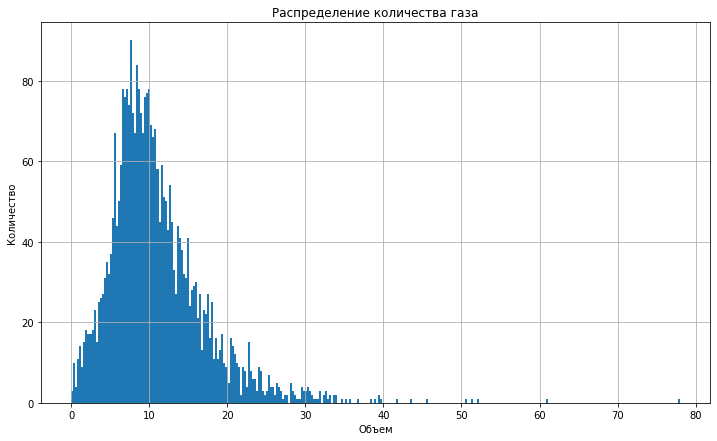

In [25]:
data_gas.drop(columns=['key']).hist(bins=300, figsize=(12,7))
plt.title('Распределение количества газа')
plt.ylabel('Количество')
plt.xlabel('Объем')
plt.show()

В данных есть показатели, которые преобладают над другими и выбиваются из общего распределения, вероятно, что операторы выбирают похожие значения для похожих партий. Также максимальные показатели могут быть выбросами ввиду своей редкости, в дальнейшем они могут исказить работу модели, рассматривать придется конекретно.

In [26]:
data_gas.loc[data_gas['газ_1'] > 70, 'key']

319    322
Name: key, dtype: int64

In [27]:
data_arc.loc[data_arc['key'] == 322]

,key,начало_нагрева_дугой,конец_нагрева_дугой,активная_мощность,реактивная_мощность
1487,322,2019-05-15 09:06:35,2019-05-15 09:09:04,0.518544,0.382905
1488,322,2019-05-15 09:11:07,2019-05-15 09:15:11,0.801966,0.582975
1489,322,2019-05-15 09:20:16,2019-05-15 09:25:33,1.019583,0.815634
1490,322,2019-05-15 09:34:19,2019-05-15 09:35:50,0.294657,0.212946
1491,322,2019-05-15 09:41:04,2019-05-15 09:43:09,0.451133,0.363475
1492,322,2019-05-15 09:46:05,2019-05-15 09:51:35,1.247301,0.979751
1493,322,2019-05-15 09:57:01,2019-05-15 09:58:49,0.405259,0.317796
1494,322,2019-05-15 10:02:40,2019-05-15 10:05:47,0.707713,0.559410
1495,322,2019-05-15 10:08:34,2019-05-15 10:10:26,0.407723,0.321421
1496,322,2019-05-15 10:35:03,2019-05-15 10:36:47,0.309299,0.375072


Процесс подготовки сплава длился очень долго, почти 2 часа, произведено 13 циклов нагрева, скорее всего показатель затраченного газа не является выбросом, но может исказить данные, поэтому будет удалён.

### data_temp — результаты измерения температуры

In [28]:
info(data_temp)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           15907 non-null  int64  
 1   Время замера  15907 non-null  object 
 2   Температура   13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0


(15907, 3)

None

,key,Температура
count,15907.000000,13006.000000
mean,1607.880870,1591.840920
std,942.212073,21.375851
min,1.000000,1191.000000
25%,790.000000,1581.000000
50%,1618.000000,1591.000000
75%,2427.000000,1601.000000
max,3241.000000,1705.000000


Таблица содержит ключевой признак, в ней имеются пропуски, соответственно, данные о партиях без итоговой температуры использованы в моделировании не будут.

In [29]:
data_temp.columns = register(data_temp)

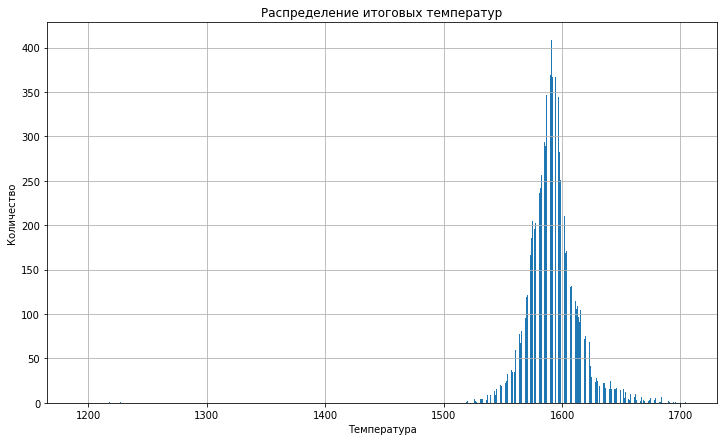

In [30]:
data_temp.drop(columns=['key']).hist(bins=1000, figsize=(12,7))
plt.title('Распределение итоговых температур')
plt.ylabel('Количество')
plt.xlabel('Температура')
plt.show()

Имеются значения температур ниже температуры плавления сплава, показатели ниже 1500 не будут использоваться в обучении модели.

### data_wire — данные о проволочных материалах (объём)

In [31]:
info(data_wire)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


(3081, 10)

None

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060483,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


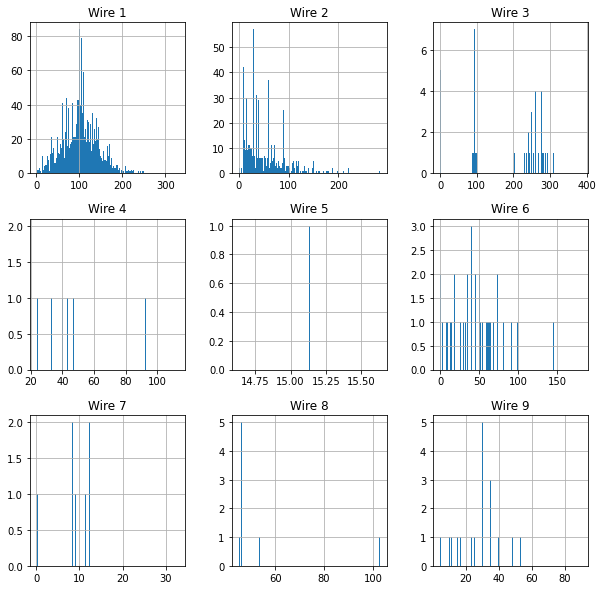

In [32]:
data_wire.drop(columns=['key']).hist(figsize=(10,10), bins=300)
plt.show()

Можно сказать, что проволочные материалы использутся неравномерно, нкоторые использовались всего один зар за наблюдаемый период (Wire 5), ввиду того, что нам не известны материалы, которые представлены столбцами этой таблицы, будем рассматривать их суммарно, также как и сыпучие материалы.

### data_wire_time — данные о проволочных материалах (время)

In [33]:
info(data_wire_time)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN


(3081, 10)

None

,key
count,3081.000000
mean,1623.426485
std,932.996726
min,1.000000
25%,823.000000
50%,1619.000000
75%,2434.000000
max,3241.000000


Аналогично данным о сыпучих материалах, в таблице представлено время добавления проволоки в сплав, данныая информация не является ключевой для составления модели.

Дополнительно можно сделать вывод, что учитывая размеры датафреймов о подаче дополнительных материалов в сплав, большая часть партий дополнительных присадок не получало. Возможно, это связано с изготовлением нескольких разных марок стали.

Изучение данных позволило отметить ряд потенциальных признаков для обучения модели:

**Признаки:**

    - температура (целевой)
    - всего присадок затрачено
    - количество присадок - шт
    - месяц производства партии (от погодных условий зависит температура материалов и сопротивляемость электродов, которыми плавят сталь)
    - проволока суммарно
    - количество источников проволоки
    - газ
    - начальная мощность
    - конечная мощность
    - максимальная мощность за все итерации прогрева
    - полная мощность
    - длительность нагрева

## Предобработка данных, разработка модели

**Описание данных**

Данные состоят из файлов, полученных из разных источников:

- `data_arc.csv` — данные об электродах;
- `data_bulk.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time.csv` *—* данные о подаче сыпучих материалов (время);
- `data_gas.csv` — данные о продувке сплава газом;
- `data_temp.csv` — результаты измерения температуры;
- `data_wire.csv` — данные о проволочных материалах (объём);
- `data_wire_time.csv` — данные о проволочных материалах (время).

### Работа с аномалиями

При удалении выбросов будем отталкиваться от таблицы data_temp, для разработки модели не подойдут значения ниже температуры плавления стали. Для этого необходимо отсечь значения ниже 1400 градусов. Очистку от выбросов произведем только на обучающей выборке.

In [34]:
data_temp.isna().sum()

key                0
время_замера       0
температура     2901
dtype: int64

In [35]:
data_temp.loc[data_temp['температура'] < 1400, 'температура'].count()

7

In [36]:
data_temp = data_temp.drop(index=data_temp[data_temp['температура'] < 1400].index, axis=1)

In [37]:
data_temp = data_temp.dropna()

In [38]:
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12999 entries, 0 to 15902
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           12999 non-null  int64  
 1   время_замера  12999 non-null  object 
 2   температура   12999 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 406.2+ KB


Выбросы устранены, сгенерируем один из признаков.

In [39]:
data_temp

,key,время_замера,температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0
...,...,...,...
15878,3237,2019-08-31 22:44:04,1569.0
15883,3238,2019-08-31 23:30:31,1584.0
15886,3239,2019-09-01 01:31:47,1598.0
15894,3240,2019-09-01 02:39:01,1617.0


### Формирование признаков

За основу возьмем таблицу data_temp, к ней будем добавлять признаки.

In [40]:
data_temp['время_замера'] = pd.to_datetime(
    data_temp['время_замера'], format='%Y-%m-%d %H:%M:%S')

#### **Месяц производства партии**

In [41]:
data_temp['month'] = pd.DatetimeIndex(data_temp['время_замера']).month

In [42]:
data_temp['week'] = pd.DatetimeIndex(data_temp['время_замера']).week

In [43]:
data_temp['dayofweek'] = pd.DatetimeIndex(data_temp['время_замера']).dayofweek

In [44]:
data_temp.head()

,key,время_замера,температура,month,week,dayofweek
0,1,2019-05-03 11:16:18,1571.0,5,18,4
1,1,2019-05-03 11:25:53,1604.0,5,18,4
2,1,2019-05-03 11:29:11,1618.0,5,18,4
3,1,2019-05-03 11:30:01,1601.0,5,18,4
4,1,2019-05-03 11:30:39,1613.0,5,18,4


In [45]:
data_temp_start = data_temp.drop_duplicates('key', keep='first')
data_temp_start = data_temp_start.set_index('key')
data_temp_start.columns = ['время_замера_s', 'температура_s', 'month', 'week_s', 'dayofweek_s']

In [46]:
data_temp_finish = data_temp.drop(columns=['month']).drop_duplicates('key', keep='last')
data_temp_finish = data_temp_finish.set_index('key')
data_temp_finish.columns = ['время_замера_f', 'температура_f', 'week_f', 'dayofweek_f']

In [47]:
data_temp_start = pd.concat([data_temp_start, data_temp_finish], join='inner', axis=1)

In [48]:
data_temp_start['full_time_sec'] = \
(data_temp_start['время_замера_s'] - data_temp_start['время_замера_f']).dt.seconds.astype('int')

In [49]:
data_temp_start = data_temp_start.drop(columns=['время_замера_s', 'время_замера_f', 'week_f', 'dayofweek_f'])

In [50]:
data_temp_start.head()

,температура_s,month,week_s,dayofweek_s,температура_f,full_time_sec
key,,,,,,
1,1571.0,5,18,4,1613.0,85539
2,1581.0,5,18,4,1602.0,85095
3,1596.0,5,18,4,1599.0,85100
4,1601.0,5,18,4,1625.0,86012
5,1576.0,5,18,4,1602.0,85638


In [51]:
data_temp_start = data_temp_start.drop(index=data_temp_start[data_temp_start['full_time_sec'] == 0].index, axis=1)

In [52]:
data = data_temp_start.copy()

Сформируем признак - стартовая температура сплава

In [53]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2475 entries, 1 to 2499
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   температура_s  2475 non-null   float64
 1   month          2475 non-null   int64  
 2   week_s         2475 non-null   int64  
 3   dayofweek_s    2475 non-null   int64  
 4   температура_f  2475 non-null   float64
 5   full_time_sec  2475 non-null   int64  
dtypes: float64(2), int64(4)
memory usage: 135.4 KB


#### **Количество присадок и суммарный объем**

In [54]:
data_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   bulk_1   252 non-null    float64
 2   bulk_2   22 non-null     float64
 3   bulk_3   1298 non-null   float64
 4   bulk_4   1014 non-null   float64
 5   bulk_5   77 non-null     float64
 6   bulk_6   576 non-null    float64
 7   bulk_7   25 non-null     float64
 8   bulk_8   1 non-null      float64
 9   bulk_9   19 non-null     float64
 10  bulk_10  176 non-null    float64
 11  bulk_11  177 non-null    float64
 12  bulk_12  2450 non-null   float64
 13  bulk_13  18 non-null     float64
 14  bulk_14  2806 non-null   float64
 15  bulk_15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


In [55]:
len(data_bulk.columns.to_list())

16

In [56]:
data_bulk['bulk_count'] = len(data_bulk.columns.to_list()) - 1 - data_bulk.isna().sum(axis=1)

In [57]:
data_bulk['bulk_resource'] = data_bulk.drop(columns=['key', 'bulk_count']).sum(axis=1)

Добавим данные в финальную таблицу по индексу.

In [58]:
data_bulk = data_bulk.set_index('key')

In [59]:
data = pd.concat([data, data_bulk.loc[:, 'bulk_count':'bulk_resource']], join='inner', axis=1)

In [60]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2407 entries, 1 to 2499
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   температура_s  2407 non-null   float64
 1   month          2407 non-null   int64  
 2   week_s         2407 non-null   int64  
 3   dayofweek_s    2407 non-null   int64  
 4   температура_f  2407 non-null   float64
 5   full_time_sec  2407 non-null   int64  
 6   bulk_count     2407 non-null   int64  
 7   bulk_resource  2407 non-null   float64
dtypes: float64(3), int64(5)
memory usage: 169.2 KB


#### Количество проволочных материалов и суммарный объем

Добавление признаков производится аналогично предыдущему пункту

In [61]:
data_wire.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [62]:
data_wire = data_wire.set_index('key')

In [63]:
data_wire['wire_count'] = len(data_wire.columns.to_list()) - data_wire.isna().sum(axis=1)

In [64]:
data_wire['wire_resource'] = data_wire.drop(columns=['wire_count']).sum(axis=1)

In [65]:
data_wire.head()

,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,wire_count,wire_resource
key,,,,,,,,,,,
1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,60.059998
2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,96.052315
3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,91.160157
4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,89.063515
5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,98.352796


Добавление признаков в итоговую таблицу

In [66]:
data = pd.concat([data, data_wire.loc[:, 'wire_count':'wire_resource']], join='inner', axis=1)

In [67]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2331 entries, 1 to 2499
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   температура_s  2331 non-null   float64
 1   month          2331 non-null   int64  
 2   week_s         2331 non-null   int64  
 3   dayofweek_s    2331 non-null   int64  
 4   температура_f  2331 non-null   float64
 5   full_time_sec  2331 non-null   int64  
 6   bulk_count     2331 non-null   int64  
 7   bulk_resource  2331 non-null   float64
 8   wire_count     2331 non-null   int64  
 9   wire_resource  2331 non-null   float64
dtypes: float64(4), int64(6)
memory usage: 200.3 KB


#### Данные о продувке сплава газом

Таблица содержит один столбец без пропусков, объединение по индексу.

In [68]:
data_gas = data_gas.set_index('key')

In [69]:
data = pd.concat([data, data_gas], join='inner', axis=1)

In [70]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2329 entries, 1 to 2499
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   температура_s  2329 non-null   float64
 1   month          2329 non-null   int64  
 2   week_s         2329 non-null   int64  
 3   dayofweek_s    2329 non-null   int64  
 4   температура_f  2329 non-null   float64
 5   full_time_sec  2329 non-null   int64  
 6   bulk_count     2329 non-null   int64  
 7   bulk_resource  2329 non-null   float64
 8   wire_count     2329 non-null   int64  
 9   wire_resource  2329 non-null   float64
 10  газ_1          2329 non-null   float64
dtypes: float64(5), int64(6)
memory usage: 218.3 KB


#### Данные об электродах

Из данной таблицы потребуется информация о начальной мощности, конечной мощности и максимальной мощности за все итерации, также сгенерируем признаки полная мощность и длительность нагрева, дополнительно добавим признак - средняя длительность одной итерации нагрева.

In [71]:
data_arc.head()

,key,начало_нагрева_дугой,конец_нагрева_дугой,активная_мощность,реактивная_мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397


In [72]:
# перевод дат в формат дат
data_arc['начало_нагрева_дугой'] = pd.to_datetime(
    data_arc['начало_нагрева_дугой'], format='%Y-%m-%d %H:%M:%S')

data_arc['конец_нагрева_дугой'] = pd.to_datetime(
    data_arc['конец_нагрева_дугой'], format='%Y-%m-%d %H:%M:%S')

**Получим общую длительность нагрева в секундах**

In [73]:
data_arc['time_warm_sec'] = (data_arc['конец_нагрева_дугой'] - data_arc['начало_нагрева_дугой']).dt.seconds.astype('int')

In [74]:
data_arc.head()

,key,начало_нагрева_дугой,конец_нагрева_дугой,активная_мощность,реактивная_мощность,time_warm_sec
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084,228
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285,185
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805,172
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669,365
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397,148


In [75]:
data_arc_sec = data_arc.pivot_table(index='key', values=['time_warm_sec', 'активная_мощность', 'реактивная_мощность'],
                                    aggfunc=['sum', 'mean'])

In [76]:
data_arc_sec.head()

sum                                                mean  \
    time_warm_sec активная_мощность реактивная_мощность time_warm_sec   
key                                                                     
1            1098          4.878147            3.183241        219.60   
2             811          3.052598            1.998112        202.75   
3             655          2.525882            1.599076        131.00   
4             741          3.209250            2.060298        185.25   
5             869          3.347173            2.252643        217.25   

                                           
    активная_мощность реактивная_мощность  
key                                        
1            0.975629            0.636648  
2            0.763150            0.499528  
3            0.505176            0.319815  
4            0.802313            0.515074  
5            0.836793            0.563161

In [77]:
# фикс мультииндекса
data_arc_sec = data_arc_sec.droplevel(level=0, axis=1)

In [78]:
data_arc_sec.head()

,time_warm_sec,активная_мощность,реактивная_мощность,time_warm_sec,активная_мощность,реактивная_мощность
key,,,,,,
1,1098,4.878147,3.183241,219.60,0.975629,0.636648
2,811,3.052598,1.998112,202.75,0.763150,0.499528
3,655,2.525882,1.599076,131.00,0.505176,0.319815
4,741,3.209250,2.060298,185.25,0.802313,0.515074
5,869,3.347173,2.252643,217.25,0.836793,0.563161


In [79]:
data_arc_sec.columns = ['time_warm_sec', 'act_sum', 'react_sum',
                       'time_warm_mean', 'act_mean', 'react_mean']

In [80]:
data_arc = data_arc.drop(columns=['time_warm_sec'])

**Формируем данные о начале процесса**

In [81]:
data_arc_start = data_arc.drop_duplicates('key', keep='first')

In [82]:
data_arc_start = data_arc_start.set_index('key')

In [83]:
data_arc_start = data_arc_start.drop(columns=['конец_нагрева_дугой'])

In [84]:
data_arc_start = data_arc_start.rename(columns={'активная_мощность':'act_start', 'реактивная_мощность':'react_start'})

In [85]:
data_arc_start.head()

,начало_нагрева_дугой,act_start,react_start
key,,,
1,2019-05-03 11:02:14,0.976059,0.687084
2,2019-05-03 11:34:14,0.438063,0.283043
3,2019-05-03 12:06:54,1.062053,0.671494
4,2019-05-03 12:39:37,0.875313,0.614404
5,2019-05-03 13:11:13,0.950026,0.690523


Эту таблицу дополним остальными признаками

**Формируем данные об окончании процесса**

In [86]:
data_arc_finish = data_arc.drop_duplicates('key', keep='last')

In [87]:
data_arc_finish = data_arc_finish.set_index('key')

In [88]:
data_arc_finish = data_arc_finish.drop(columns=['начало_нагрева_дугой'])

In [89]:
data_arc_finish = data_arc_finish.rename(columns={'активная_мощность':'act_finish', 'реактивная_мощность':'react_finish'})

In [90]:
data_arc_start = pd.concat([data_arc_start, data_arc_finish], join='inner', axis=1)

In [91]:
data_arc_start.head()

,начало_нагрева_дугой,act_start,react_start,конец_нагрева_дугой,act_finish,react_finish
key,,,,,,
1,2019-05-03 11:02:14,0.976059,0.687084,2019-05-03 11:28:37,0.692755,0.414397
2,2019-05-03 11:34:14,0.438063,0.283043,2019-05-03 11:53:18,0.827743,0.516874
3,2019-05-03 12:06:54,1.062053,0.671494,2019-05-03 12:32:19,0.250280,0.155901
4,2019-05-03 12:39:37,0.875313,0.614404,2019-05-03 12:57:50,1.220955,0.754719
5,2019-05-03 13:11:13,0.950026,0.690523,2019-05-03 13:33:55,0.267457,0.181992


Аггрегируем данные мощности по формуле:
Полная мощность = √ (Активная мощность2 + Реактивная мощность2)

In [92]:
data_arc_start['full_power_start'] = (data_arc_start['act_start']**2 + data_arc_start['react_start'])**(0.5)

In [93]:
data_arc_start['full_power_finish'] = (data_arc_start['act_finish']**2 + data_arc_start['react_finish'])**(0.5)

Подготовим таблицу к объединению с основным датафреймом

In [94]:
data_arc_start = data_arc_start.drop(columns=['начало_нагрева_дугой', 'конец_нагрева_дугой'])

Добавим в таблицу суммарное время нагрева

In [95]:
data_arc_start = pd.concat([data_arc_start, data_arc_sec], join='inner', axis=1)

In [96]:
data_arc_start.head()

,act_start,react_start,act_finish,react_finish,full_power_start,full_power_finish,time_warm_sec,act_sum,react_sum,time_warm_mean,act_mean,react_mean
key,,,,,,,,,,,,
1,0.976059,0.687084,0.692755,0.414397,1.280537,0.945678,1098,4.878147,3.183241,219.60,0.975629,0.636648
2,0.438063,0.283043,0.827743,0.516874,0.689161,1.096372,811,3.052598,1.998112,202.75,0.763150,0.499528
3,1.062053,0.671494,0.250280,0.155901,1.341436,0.467484,655,2.525882,1.599076,131.00,0.505176,0.319815
4,0.875313,0.614404,1.220955,0.754719,1.174980,1.498483,741,3.209250,2.060298,185.25,0.802313,0.515074
5,0.950026,0.690523,0.267457,0.181992,1.262169,0.503512,869,3.347173,2.252643,217.25,0.836793,0.563161


#### Формирование итоговой таблицы

In [97]:
data = pd.concat([data, data_arc_start], join='inner', axis=1)

In [98]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2329 entries, 1 to 2499
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   температура_s      2329 non-null   float64
 1   month              2329 non-null   int64  
 2   week_s             2329 non-null   int64  
 3   dayofweek_s        2329 non-null   int64  
 4   температура_f      2329 non-null   float64
 5   full_time_sec      2329 non-null   int64  
 6   bulk_count         2329 non-null   int64  
 7   bulk_resource      2329 non-null   float64
 8   wire_count         2329 non-null   int64  
 9   wire_resource      2329 non-null   float64
 10  газ_1              2329 non-null   float64
 11  act_start          2329 non-null   float64
 12  react_start        2329 non-null   float64
 13  act_finish         2329 non-null   float64
 14  react_finish       2329 non-null   float64
 15  full_power_start   2329 non-null   float64
 16  full_power_finish  2329 

In [99]:
data.head()

,температура_s,month,week_s,dayofweek_s,температура_f,full_time_sec,bulk_count,bulk_resource,wire_count,wire_resource,...,act_finish,react_finish,full_power_start,full_power_finish,time_warm_sec,act_sum,react_sum,time_warm_mean,act_mean,react_mean
key,,,,,,,,,,,,,,,,,,,,,
1,1571.0,5,18,4,1613.0,85539,4,553.0,1,60.059998,...,0.692755,0.414397,1.280537,0.945678,1098,4.878147,3.183241,219.60,0.975629,0.636648
2,1581.0,5,18,4,1602.0,85095,4,582.0,1,96.052315,...,0.827743,0.516874,0.689161,1.096372,811,3.052598,1.998112,202.75,0.763150,0.499528
3,1596.0,5,18,4,1599.0,85100,4,544.0,1,91.160157,...,0.250280,0.155901,1.341436,0.467484,655,2.525882,1.599076,131.00,0.505176,0.319815
4,1601.0,5,18,4,1625.0,86012,4,595.0,1,89.063515,...,1.220955,0.754719,1.174980,1.498483,741,3.209250,2.060298,185.25,0.802313,0.515074
5,1576.0,5,18,4,1602.0,85638,4,584.0,2,98.352796,...,0.267457,0.181992,1.262169,0.503512,869,3.347173,2.252643,217.25,0.836793,0.563161


In [100]:
data.columns.to_list()

['температура_s',
 'month',
 'week_s',
 'dayofweek_s',
 'температура_f',
 'full_time_sec',
 'bulk_count',
 'bulk_resource',
 'wire_count',
 'wire_resource',
 'газ_1',
 'act_start',
 'react_start',
 'act_finish',
 'react_finish',
 'full_power_start',
 'full_power_finish',
 'time_warm_sec',
 'act_sum',
 'react_sum',
 'time_warm_mean',
 'act_mean',
 'react_mean']

In [101]:
data = data.rename(columns={'газ_1':'gas', 'температура_s':'temp_start', 'температура_f':'target'})

In [102]:
data.columns

Index(['temp_start', 'month', 'week_s', 'dayofweek_s', 'target',
       'full_time_sec', 'bulk_count', 'bulk_resource', 'wire_count',
       'wire_resource', 'gas', 'act_start', 'react_start', 'act_finish',
       'react_finish', 'full_power_start', 'full_power_finish',
       'time_warm_sec', 'act_sum', 'react_sum', 'time_warm_mean', 'act_mean',
       'react_mean'],
      dtype='object')

In [103]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2329 entries, 1 to 2499
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   temp_start         2329 non-null   float64
 1   month              2329 non-null   int64  
 2   week_s             2329 non-null   int64  
 3   dayofweek_s        2329 non-null   int64  
 4   target             2329 non-null   float64
 5   full_time_sec      2329 non-null   int64  
 6   bulk_count         2329 non-null   int64  
 7   bulk_resource      2329 non-null   float64
 8   wire_count         2329 non-null   int64  
 9   wire_resource      2329 non-null   float64
 10  gas                2329 non-null   float64
 11  act_start          2329 non-null   float64
 12  react_start        2329 non-null   float64
 13  act_finish         2329 non-null   float64
 14  react_finish       2329 non-null   float64
 15  full_power_start   2329 non-null   float64
 16  full_power_finish  2329 

Таким образом, в ходе анализа был составлен датасет из 21 признака, которые необходимо проверить на мультиколлинеарность.

### Проверка на мультиколлинеарность

In [104]:
# Выделим признаки для расчета
interval_cols = data.columns.to_list()
phik_overview = data.phik_matrix(interval_cols=interval_cols)
#phik_overview.round(2)

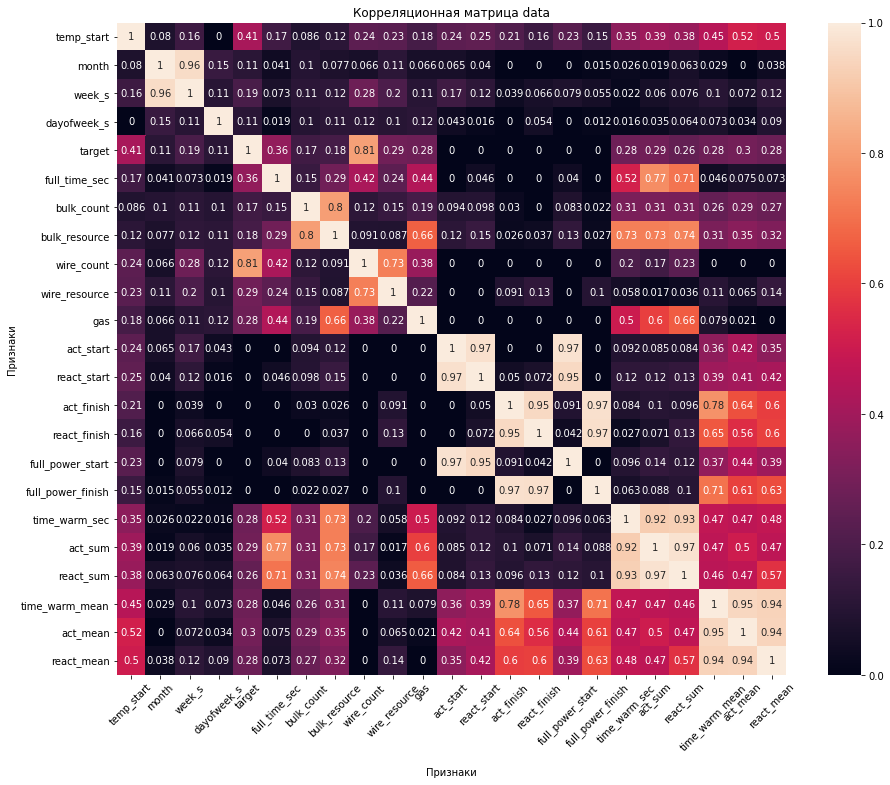

In [105]:
# Строим матрицу корреляции
plt.figure(figsize=(15,12))
plot_correlation_matrix = sns.heatmap(phik_overview, annot = True)
plot_correlation_matrix.set(xlabel='\nПризнаки', ylabel='Признаки',
                            title = "Корреляционная матрица data")
plt.yticks(rotation=0)
plt.xticks(rotation=45)
plt.show()

Матрица показала, что наибольшее влияние на целевой признак оказывает значение начальной температуры. Удивительно, но на втором месте по влиянию на целевой признак находится значение месяца. Третий по значимости признак - количество проволочных материалов, подаваемых в сплав, что логично, ведь у каждого материала своя температура плавления. Значения bulk_count и bulk_resource сильно коррелируют между собой. Наибольшая корреляция между значениями мощности, которые были агрегированы, оставим только значения полной мощности.

Для дальнейше работы не будем использовать значения с корреляцией более 0.85

In [106]:
data = data.drop(columns=['month', 'week_s', 'dayofweek_s'])

In [107]:
data = data.drop(columns=['act_start', 'react_start', 'react_finish', 'act_finish',
                         'act_sum', 'react_sum', 'time_warm_mean', 'react_mean'])

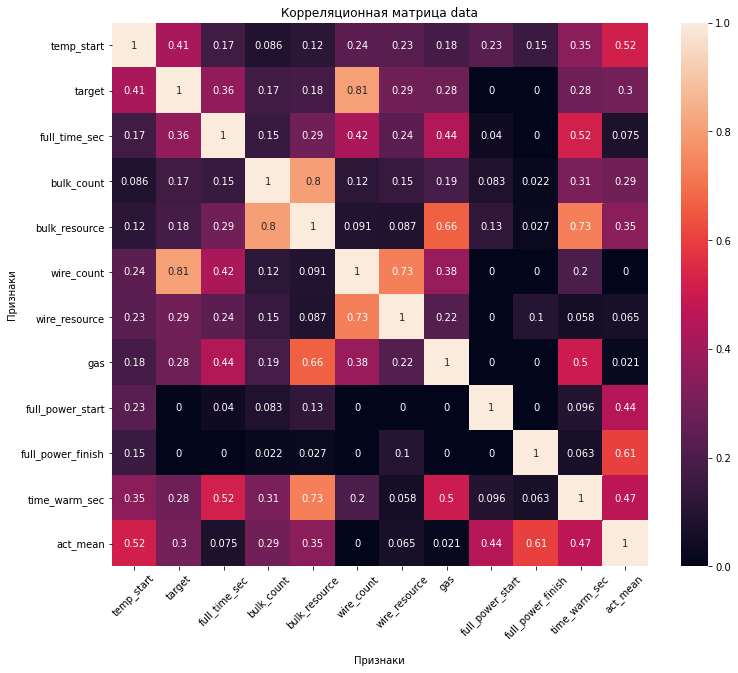

In [108]:
# Выделим признаки для расчета
interval_cols = data.columns.to_list()
phik_overview = data.phik_matrix(interval_cols=interval_cols)
#phik_overview.round(2)

# Строим матрицу корреляции
plt.figure(figsize=(12,10))
plot_correlation_matrix = sns.heatmap(phik_overview, annot = True)
plot_correlation_matrix.set(xlabel='\nПризнаки', ylabel='Признаки',
                            title = "Корреляционная матрица data")
plt.yticks(rotation=0)
plt.xticks(rotation=45)
plt.show()

Для дальнейшей работы модели целесообразно оставить 11 признаков.

## Разработка моделей

### Выборки, пайплайн

В категориальные переменные предлагается определить значения дня недели и количество источников проволоки и сырья так, как они предположительно определяют вид стали.

In [109]:
X = data.drop(columns=['target'])
y = data['target']

In [110]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=270323)

In [111]:
cat_columns = ['bulk_count', 'wire_count']
num_columns = ['temp_start',
 'full_time_sec',
 'bulk_resource',
 'wire_resource',
 'gas',
 'full_power_start',
 'full_power_finish',
 'time_warm_sec',
 'act_mean']

Поиск подходящей модели будем осуществлять с момощью Pieline и RandomSearch

In [112]:
num_pipline = Pipeline([('scaler', StandardScaler())])

num_pipline_1 = Pipeline([('encoder', OneHotEncoder())])


columns_pipeline = ColumnTransformer([('num_cols', num_pipline, num_columns),
                                      ('cat_encoder', num_pipline_1, cat_columns)],
                                        remainder='passthrough')

In [113]:
pipeline = make_pipeline(columns_pipeline)
pipeline.steps.append(('clf', DummyRegressor()))
pipeline

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num_cols',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['temp_start',
                                                   'full_time_sec',
                                                   'bulk_resource',
                                                   'wire_resource', 'gas',
                                                   'full_power_start',
                                                   'full_power_finish',
                                                   'time_warm_sec',
                                                   'act_mean']),
                                                 ('cat_encoder',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder())]),
                                                  ['bulk_count',
                                                   'wire_count'])])),
                ('clf', DummyRegressor())])

### Подбор лучшей модели и параметров

Выбор лучшей модели будем осуществлять между тремя моделями:
- Линейная регрессия
- Случайный лес
- Градиентный бустинг
- CatBoostRegressor

Параллельно проведем подбор наилучших параметров и кросс-валидацию.

In [114]:
estimators_range = uniform(10,200).rvs(50, random_state=270323).astype(int)
max_depth_range = uniform(1,30).rvs(10, random_state=270323).astype(int)

In [116]:
params = [{
    'clf': [LinearRegression()],
    },
    {
    'clf': [GradientBoostingRegressor(random_state=270323)],
    'clf__n_estimators': [i for i in np.arange(100, 500, 10)],
    'clf__max_depth': [i for i in np.arange(1, 15, 2)],
    'clf__min_samples_split': [i for i in np.arange(4, 14, 2)],
    'clf__max_features': ['auto', 'sqrt', 'log2'],
    'columntransformer__num_cols__scaler': [None],
    'columntransformer__cat_encoder__encoder': [None]
    },
    {
    'clf': [RandomForestRegressor(random_state=270323)],
    'clf__n_estimators': [i for i in np.arange(150, 500, 15)],
    'clf__min_samples_split': [i for i in np.arange(4, 14, 2)],
    'clf__bootstrap': [True, False],
    'columntransformer__num_cols__scaler': [None],
    'columntransformer__cat_encoder__encoder': [None]
    },
    {
    'clf': [CatBoostRegressor(random_state=270323, verbose=0)],
    'clf__n_estimators': estimators_range,
    'clf__max_depth': max_depth_range,
    'columntransformer__num_cols__scaler': [None],
    'columntransformer__cat_encoder__encoder': [None]
    }]

In [117]:
grid = RandomizedSearchCV(pipeline,
                    params,
                    n_iter=100,
                    cv=3,
                    verbose=2,
                    random_state=270323,
                    scoring='neg_mean_absolute_error',
                    n_jobs=-1)

In [118]:
%%time
grid.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END clf=<catboost.core.CatBoostRegressor object at 0x7fe989fe2e20>, clf__max_depth=15, clf__n_estimators=168, columntransformer__cat_encoder__encoder=None, columntransformer__num_cols__scaler=None; total time= 4.8min
[CV] END clf=<catboost.core.CatBoostRegressor object at 0x7fe989fe2e20>, clf__max_depth=15, clf__n_estimators=168, columntransformer__cat_encoder__encoder=None, columntransformer__num_cols__scaler=None; total time= 4.8min
[CV] END clf=<catboost.core.CatBoostRegressor object at 0x7fe989fe2e20>, clf__max_depth=15, clf__n_estimators=168, columntransformer__cat_encoder__encoder=None, columntransformer__num_cols__scaler=None; total time= 4.8min
[CV] END clf=<catboost.core.CatBoostRegressor object at 0x7fe989fe2e20>, clf__max_depth=15, clf__n_estimators=157, columntransformer__cat_encoder__encoder=None, columntransformer__num_cols__scaler=None; total time= 4.5min
[CV] END clf=<catboost.core.CatBoostRegressor obj

KeyboardInterrupt: 

In [ ]:
grid.best_params_

In [ ]:
abs(grid.best_score_)

Наилучшим образом себя показала модель CatBoostRegressor с итогым значением 6.17 МАЕ на тестовой выборке. Для модели были подобраны следующие параметры:
- количество деревьев - 192,
- количество ветвей - 2

In [970]:
X_test.head()

,temp_start,full_time_sec,bulk_count,bulk_resource,wire_count,wire_resource,gas,full_power_start,full_power_finish,time_warm_sec,act_mean
key,,,,,,,,,,,
1216,1615.0,83553,3,461.0,1,100.245599,7.690214,0.748755,0.576434,821,0.379795
341,1563.0,85395,3,527.0,2,92.650478,9.300885,0.777467,0.937306,766,1.056644
484,1581.0,83755,4,726.0,1,120.229194,11.499156,0.962070,0.746537,881,0.924391
2077,1578.0,84962,4,528.0,1,83.996635,7.953611,0.649385,0.623630,701,0.665217
2243,1580.0,85171,2,707.0,1,58.050720,10.967266,0.880695,0.783625,683,0.585860


### Проверка качества модели на тестовой выборке

In [971]:
predict = grid.predict(X_test)

In [972]:
mean_absolute_error(y_test, predict)

5.895317450618136

В результате работы, мы получили модель, прогнозирующую температуру итогового сырья с точностью 5.89 МАЕ на тестовой выборке. При этом, единственный параметр очищенный от выбросов - это начальная температура, которая фактически не может быть меньше температуры плавления стали. Значительную роль в данном случае сыграло обили признаков для обучения модели.

### Исследование важности признаков

In [973]:
# Функция визуализации значимости признаков
def show_coef(names, coef, positive=False):
    plt.figure(figsize=(12,5))
    if positive:
        sns.barplot(y=names,x=abs(coef), orient='h')
    else:
        sns.barplot(y=names,x=coef, orient='h')
    plt.tight_layout
    plt.xlabel('Значимость')
    plt.ylabel('Признак')
    plt.title('Значимость признаков в построенной модели')
    plt.grid(True)
    plt.show()

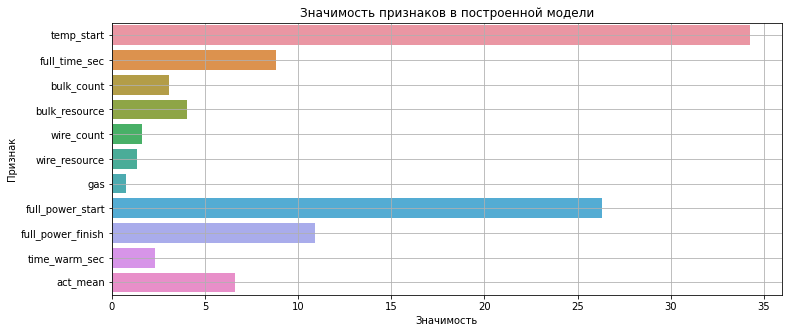

In [974]:
# Определим значимость признаков обученной модели
show_coef(X_train.columns.to_list(), grid.best_estimator_.steps[1][1].feature_importances_)

Визуализация значимости признаков показала, что наибольшую значимость имеет параметр начальной температуры сырья, что соответствует логике. 

При этом, на втором месте показатель стартовой полной мощности.

Третий по значимости признак - время нагрева.

# Отчёт о выполненной работе

Для выполнения задачи оптимизации производственных расходов, путем уменьшения потребления, была сформирована задача: Разработать предсказательную модель температуры расплавленного состояния сплава.

Для поэтапного выполнения поставленной задачи был составлен план работ составленный из трех тематических блоков.

**1. Ключевые вопросы**


**1.1 План работы**

*Первая часть работы*

В первой части работы проведен исследовательский анализ данных, выявлены взаимосвязи и закономерности между предоставленными таблицами. Изучение данных проводилось с помощью инструментов визуализации, а также при опросе заказчика. Также был выявлен целевой признак. Все пункты данной части выполнены в соответсвии с планом.

*Вторая часть работы*

Во второй части проведена работа по подготовке признаков для модели машинного обучения. Для этого на основании предшествующего анализа был составлен отдельный датафрейм отражающий различные показатели связанные с каждой партией стали. Также были сгенерированы дополнительные признаки позволившие повыситьточность модели. 
Признаки содержат следующую информацию: начальная температура сплава, информация о массе и количестве источников дополнительных присадок и материалов, время работы и нагрева сплава, полная и средняя мощность при изготовлении конкретной партии.
Перед применением, признаки были проверены а мультиколлинеарность.

*Третья часть работы*

Третья часть работы представляет собой непосредственный подбор лучшей модели. Для этого итоговая таблица была разделена на на обучающую и тестовую выборку в соотношении 75 и 25 % соответсвенно. Для более эффективного поиска лучшей модели и параметров бы сформирован пайплайн и словарь обучаемых моделей со списком перебираемых параметров. Оценка лучшей модели производилась с помощью кросс-валидации, итоговая метрика заявленная заказчиком mean absolute error. Также после выбора лучшей модели составлен список наиболее важных для модели признаков.

Все пункты плана выполнены в полном объёме.

**1.2 Трудности при выполнении работы**

При подготовке модели наибольшую трудность представляет изучение и подготовка данных. Для этого необходимо тщательно исследовать предоставленные материалы и вырабатывать методику по выявлению и объединению потенциально полезной для модели информации в один датафрейм. Также важно сформировать дополнительные признаки не допустив утечку данных. Дополнительную сложность вносит недостаточная осведомленнность о производственых процессах организации с которыми необходимо предварительно ознакомиться.

**1.3 Ключевые шаги**

Ключевые шаги обозначены в плане работы. Касательно промежуточных операций наиболее важными шагами можно считать формирования большого датасета содержащего все необходиме для работы модели признаки. Вторым по значимости шагом является отсеивание этих признаков на основе проверки на мультиколлинеарность признаков.

**1.4 Итоговая модель**

Наилучшим образом себя показала модель CatBoostRegressor с итогым значением 6.17 МАЕ на обучающей выборке. В результате проверки на тестововой выборке удалось определить температуру итогового сырья с точностью 5.89 МАЕ

**2. Список признаков**

target - целевой признак, выделен из таблицы data_temp. Последняя измеренная температура в партии.

temp_start - первый по важности признак, выгружен из таблицы data_temp. Начальная температура партии.

full_time_sec - продолжительность работы с ковшом, подсчитан на основе информации о продолжительности каждой итерации data_temp.

bulk_resource, bulk_count - данныые о подаче сыпучих материалов были агрегированы из таблицы data_bulk по суммарной массе и количеству источников материала.

wire_resource, wire_count - аналогично предыдущему пункту, источник данных data_wire.

full_power_start, full_power_finish - сгенерирован из данных об активной и реактивной мощности таблицы data_arc. Признак расчитан по формуле полной мощности обозначенной в работе.

gas - выгружен из таблицы data_gas в соответствии с номером партии.

time_warm_sec = родолжительность нагрева сплава, подсчитан на основе информации о продолжительности каждой итерации нагрева data_arc.

act_mean - средняя активная мощность на партию. Агрегирован на основании соответствующего столбца таблицы data_arc.

**3. Гиперпараметры лучшей модели**

Для модели были подобраны следующие параметры:

- n_estimators - 192,
- max_depth - 2
- random_state - 230323

**4. Рекомендации**

Для улучшения работы модели стоит добавить дополнительные данные о погодных условиях на момент изготовления партии. Необходимо изучить влияние этого фактора на итоговую температуру. Дополнительно можно расчитать энергозатраты на основе данных о мощности и длительности нагрева, а также промаркировать температуру в пределах нормы и превышающуюю её для данного сплава. Примечательно, что высокое влияние на итоговую метрику показали временные признаки месяц/неделя/день недели, возможно имеются некоторые закономерности связанные с логистикой, количественным и качественным составом рабочей смены.